Name: Anushka Srivastava
<br>Roll no: 2022086

#### Requirements
- Biopython library

In [1]:
# Run this first to install the Biopython library
!pip install Biopython

Necessary libraries are imported to carry out the tasks

In [3]:
# import statements
from Bio import Entrez, SeqIO
from os import path
from os import makedirs
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.Seq import Seq

### Access the NCBI database (https://www.ncbi.nlm.nih.gov/) and download the DNA sequence of the Saccharomyces cerevisiae PDC gene.

We store all the files in the directory named `output_dir` which will be automatically created on running the full code.

In [3]:
if not path.exists("output_dir"):
    makedirs("output_dir")

We are using the `nucleotide` database to search for the fasta file. After accessing the fasta sequence, we perform the file writing operation to save the sequence in a file.

In [4]:
# Function to download the fasta file for the specified accession number and storing it in the output directory
def download_fasta_sequence(email, accession_number):
  Entrez.email = email
  handle = Entrez.efetch(db = "nucleotide", id = accession_number, rettype = "fasta", retmode = "text")
  sequence = handle.read()
  file_name = accession_number + ".fasta"
  file_path = path.join("output_dir", file_name)
  with open(file_path,"w") as f:
    f.write(sequence)

According to the [NCBI](https://www.ncbi.nlm.nih.gov/datasets/gene/taxon/559292/?search=PDC) database, we see that there are PDC1, PDC5 and PDC6 genes. PDC1 and PDC5 genes are present in Chromosome XII and PDC6 gene is present in the Chromosome VII gene. We download these `fasta` files and access the gene sequence by referring to the indexes and the state (reverse complement or not) as given in NCBI.

In [5]:
email = "anushka22086@iiitd.ac.in"
accession_no = ["NC_001144.5", "NC_001139.9"]

In [6]:
for ac in accession_no:
    download_fasta_sequence(email,ac)

#### Reference
- https://www.ncbi.nlm.nih.gov/datasets/gene/taxon/559292/?search=PDC
- https://pubmed.ncbi.nlm.nih.gov/8904337/

### Use BLAST (Basic Local Alignment Search Tool) to compare the PDC gene sequence across different Saccharomyces cerevisiae strains and identify SNPs. 

By referring to the [NCBI](https://www.ncbi.nlm.nih.gov/datasets/gene/taxon/559292/?search=PDC) article, we use the information we get to extract the PDC gene from the `fasta` file of the genome sequence of the yeast.

In [1]:
def get_sequence(file, start, end):
    file_path = path.join("./output_dir", file)
    seq = ""
    for record in SeqIO.parse(file_path, "fasta"):
        seq += record.seq
    return seq[start - 1:end]

In [4]:
file1 = "NC_001144.5.fasta"
file2 = "NC_001139.9.fasta"
seq_pdc1 = get_sequence(file1, 232390, 234081).reverse_complement()
seq_pdc5 = get_sequence(file1, 410723, 412414)
seq_pdc6 = get_sequence(file2, 651290, 652981).reverse_complement()  

The obtained sequences are then stored in a file.

In [9]:
with open("./output_dir/PDC1.txt","w") as f:
    f.write(str(seq_pdc1))
with open("./output_dir/PDC5.txt","w") as f:
    f.write(str(seq_pdc5))
with open("./output_dir/PDC6.txt","w") as f:
    f.write(str(seq_pdc6))

We then set the parameters of the BLAST and then run the query sequence through the BLAST.

In [5]:
def perform_blast(query_sequence):
    blast_params = {
        "program": "blastn",
        "database": "nt",
        "sequence": query_sequence,
        "entrez_query" : "Saccharomyces cerevisiae[ORGANISM]", # Filter to search among the Saccharomyces cerevisiae strain only
        "hitlist_size" : 100, # Return size
        "megablast" : True # Return only for closely associated alignments
    }

    result = NCBIWWW.qblast(**blast_params)
    blast_records = NCBIXML.parse(result)
    return blast_records

We iterate over the obtained records and we count the number of SNPs obtained in each sequence. We skip over those records where SNPs are zero as we don't need that result. According to a [research](https://medlineplus.gov/genetics/understanding/genomicresearch/snp/#:~:text=They%20occur%20almost%20once%20in,1%20percent%20of%20the%20population) paper, SNPs occur once in every 1000 nucleotide sequence and hence, the records except those with 0 SNPs are taken into consideration in this case.
<br><br>
We print all the SNPs found along with their index and the nucleotide change.

In [6]:
pdc_input_sequence = []
pdc_match_sequence = []

def display_results(blast_records):
    for blast_record in blast_records:
        for alignment in blast_record.alignments:
            for hsp in alignment.hsps:
                snps = []
                query_seq = hsp.query
                matched_seq = hsp.sbjct
                count = 0
                # Iterate over positions in the alignment
                for i in range(len(query_seq)):
                    if query_seq[i] != matched_seq[i]:
                        count += 1
                        # SNP identified at position i
                        snps.append([i + 1, query_seq[i], matched_seq[i]])
                # Skip record with 0 SNPs
                if count == 0:
                    continue
                print("Sequence ID:", alignment.title)
                pdc_input_sequence.append(query_seq)
                pdc_match_sequence.append(matched_seq)
                print("Query sequence: {}".format(query_seq))
                print("Subject sequence: {}".format(matched_seq))
                for snp in snps:
                    print(f"SNP at position {snp[0]}: {snp[1]} -> {snp[2]}")
                print("Total SNPs identified: {}".format(count))
                print()

We then perform BLAST on each PDC sequence obtained.

In [7]:
blast_pdc1 = perform_blast(seq_pdc1)
display_results(blast_pdc1)

Sequence ID: gi|1586061137|gb|CP036478.1| Saccharomyces cerevisiae strain ySR128 chromosome XII, complete sequence
Query sequence: ATGTCTGAAATTACTTTGGGTAAATATTTGTTCGAAAGATTAAAGCAAGTCAACGTTAACACCGTTTTCGGTTTGCCAGGTGACTTCAACTTGTC-CTTGTTGGACAAGATCTACGAAGTTGAAGGTATGAGATGGGCTGGTAACGCCAACGAATTGAACGCTGCTTACGCCGCTGATGGTTACGCTCGTATCAAGGGTATGTCTTGTATCATCACCACCTTCGGTGTCGGTGAATTGTCTGCTTTGAACGGTATTGCCGGTTCTTACGCTGAACACGTCGGTGTTTTGCACGTTGTTGGTGTCCCATCCATCTCTGCTCAAGCTAAGCAATTGTTGTTGCACCACACCTTGGGTAACGGTGACTTCACTGTTTTCCACAGAATGTCTGCCAACATTTCTGAAACCACTGCTATGATCACTGACATTGCTACCGCCCCAGCTGAAATTGACAGATGTATCAGAACCACTTACGTCACCCAAAGACCAGTCTACTTAGGTTTGCCAGCTAACTTGGTCGACTTGAACGTCCCAGCTAAGTTGTTGCAAACTCCAATTGACATGTCTTTGAAGCCAAACGATGCTGAATCCGAAAAGGAAGTCATT-GACACCATCTTGGCTTTGGTCAAGGATGCTAAGAACCCAGTTATCTTGGCTGATGCTTGTTGTTCCAGACACGACGTCAAGGCTGAAACTAAGAAGTTGATTGACTTGACTCAATTCCCAGCTTTCGTCACCCCAATGGGTAAGGGTTCCATTGACGAACAACACCCAAGATACGGTGGTGTTTACGTCGGTACCTTGTCCAAGCCAGAAGTTAAGGAAGCCGTTGAATCTGCTGACTTGATTTTGTCTGTCGGTGCTTTGTTG

In [8]:
blast_pdc5 = perform_blast(seq_pdc5)
display_results(blast_pdc5)

Sequence ID: gi|1789111098|gb|CP046092.1| Saccharomyces cerevisiae strain CEN.PK113-7D chromosome XII
Query sequence: ATGTCTGAAATAACCTTAGGTAAATATTTATTTGAAAGATTGAGCCAAGTCAACTGTAACACCGTCTTCGGTTTGCCAGGTGACTTTAACTTGTCTCTT-TTGGATAAGCTTTATGAAGTCAAAGGTATGAGATGGGCTGGTAACGCTAACGAATTGAACGCTGCCTATGCTGCTGATGGTTACGCTCGTATCAAGGGTATGTCCTGTATTATTACCACCTTCGGTGTTGGTGAATTGTCTGCTTTGAATGGTATTGCCGGTTCTTACGCTGAACATGTCGGTGTTTTGCACGTTGTTGGTGTTCCATCCATCTCTTCTCAAGCTAAGCAATTGTTGTTGCATCATACCTTGGGTAACGGTGACTTCACTGTTTTCCACAGAATGTCTGCCAACATTTCTGAAACCACTGCCATGATCACTGATATTGCTAACGCTCCAGCTGAAATTGACAGATGTATCAGAACCACCTACACTACCCAAAGACCAGTCTACTTGGGTTTGCCAGCTAACTTGGTTGACTTGAACGTCCCAGCCAAGTTATTGGAAACTCCAATTGACTTGTCTTTGAAGCCAAACGACGCTGAAGCTGAAGCTGAAGTTGTTAGA-ACTGTTGTTGAATTGATCAAGGATGCTAAGAACCCAGTTATCTTGGCTGATGCTTGTGCTTCTAGACATGATGTCAAGGCTGAAACTAAGAAGTTGATGGACTTGACTCAATTCCCAGTTTACGTCACCCCAATGGGTAAGGGTGCTATTGACGAACAACACCCAAGATACGGTGGTGTTTACGTTGGTACCTTGTCTAGACCAGAAGTTAAGAAGGCTGTAGAATCTGCTGATTTGATATTGTCTATCGGTGCTTTGTTGTCTGATTTCAATA

In [9]:
blast_pdc6 = perform_blast(seq_pdc6)
display_results(blast_pdc6)

Sequence ID: gi|1389182097|gb|CP029160.1| Saccharomyces cerevisiae strain SY14 chromosome I, complete sequence
Query sequence: ATGTCTGAAATTACTCTTGGAAAATACTTATTTGAAAGATTGAAGCAAGTTAATGTTAACACCATTTTTGGGCTACCAGGCGACTTCAACTTGTCCCTATTGGACAAGATTTACGAGGTAGATGGATTGAGATGGGCTGGTAATGCAAATGAGCTGAACGCCGCCTATGCCGCCGATGGTTACGCACGCATCAAGGGTTTATCT-GTGCTGGTAACTACTTTTGGCGTAGGTGAATTATCCGCCTTGAATGGTATTGCAGGATCGTATGCAGAACACGTCGGTGTACTGCATGTTGTTGGTGTCCCCTCTATCTCCGCTCAGGCTAAGCAATTGTTGTTGCATCATACCTTGGGTAACGGTGATTTTACCGTTTTTCACAGAATGTCCGCCAATATCTCAGAAACTACATCAATGATTACAGACATTGCTACAGCCCCTTCAGAAATCGATAGGTTGATCAGGACAACATTTA--TAACACAAAGGCCTAG-CTACTTGGGGTTGCCAGCGAATTTGGTAGATCTAAAGGTTCCTGGTTCTCTT-TTGGAAAAACCGATTGATCTATCATTAAAACCTAACGATCCCGAAGCTGAAAAGGAAGTTATTGATACCGTACTAGAATTGATCCAGAATTCGAAAAACCCTGTTATACTATCGGATGCCTGTGCTTCTAGGCACAACGTTAAAAAAGAAACCCAGAAGTTAATTGATTTGACGCAATTCCCAGCTTTTGTGACACCTCTAGGTAAAGGGTCAATAGATGAACAGCATCCCAGATATGGCGGTGTTTATGTGGGAACGCTGTCCAAACAAGACGTGAAACAGGCCGTTGAGTCGGCTGATTTGATCCTTTCGGTCGGTGCTTTGCTCT

#### Reference
- https://medlineplus.gov/genetics/understanding/genomicresearch/snp/#:~:text=They%20occur%20almost%20once%20in,1%20percent%20of%20the%20population
- https://www.ncbi.nlm.nih.gov/datasets/gene/taxon/559292/?search=PDC
- https://www.tutorialspoint.com/biopython/biopython_overview_of_blast.htm
- https://www.genome.gov/genetics-glossary/Single-Nucleotide-Polymorphisms

### Use an translation tool (e.g., ExPASy Translate tool) to translate the normal and SNP-containing PDC gene sequences into amino acid sequences.

To convert a nucleotide sequence to an amino acid sequence, we simply use the `translate()` function of the Biopython library.

In [10]:
amino_input_list = []
amino_output_list = []

for i in range(len(pdc_input_sequence)):
    print("Amino acid sequence for normal sequence:")
    amino_input = Seq(pdc_input_sequence[i].replace("-","")).translate()
    print(amino_input)
    amino_input_list.append(amino_input)
    print("Amino acid sequence for SNP-containing sequence:")
    amino_output = Seq(pdc_input_sequence[i].replace("-","")).translate()
    print(amino_output)
    amino_output_list.append(amino_output)
    print()

Amino acid sequence for normal sequence:
MSEITLGKYLFERLKQVNVNTVFGLPGDFNLSLLDKIYEVEGMRWAGNANELNAAYAADGYARIKGMSCIITTFGVGELSALNGIAGSYAEHVGVLHVVGVPSISAQAKQLLLHHTLGNGDFTVFHRMSANISETTAMITDIATAPAEIDRCIRTTYVTQRPVYLGLPANLVDLNVPAKLLQTPIDMSLKPNDAESEKEVIDTILALVKDAKNPVILADACCSRHDVKAETKKLIDLTQFPAFVTPMGKGSIDEQHPRYGGVYVGTLSKPEVKEAVESADLILSVGALLSDFNTGSFSYSYKTKNIVEFHSDHMKIRNATFPGVQMKFVLQKLLTTIADAAKGYKPVAVPARTPANAAVPASTPLKQEWMWNQLGNFLQEGDVVIAETGTSAFGINQTTFPNNTYGISQVLWGSIGFTTGATLGAAFAAEEIDPKKRVILFIGDGSLQLTVQEISTMIRWGLKPYLFVLNNDGYTIEKLIHGPKAQYNEIQGWDHLSLLPTFGAKDYETHRVATTGEWDKLTQDKSFNDNSKIRMIEIMLPVFDAPQNLVEQAKLTAATNAKQ*
Amino acid sequence for SNP-containing sequence:
MSEITLGKYLFERLKQVNVNTVFGLPGDFNLSLLDKIYEVEGMRWAGNANELNAAYAADGYARIKGMSCIITTFGVGELSALNGIAGSYAEHVGVLHVVGVPSISAQAKQLLLHHTLGNGDFTVFHRMSANISETTAMITDIATAPAEIDRCIRTTYVTQRPVYLGLPANLVDLNVPAKLLQTPIDMSLKPNDAESEKEVIDTILALVKDAKNPVILADACCSRHDVKAETKKLIDLTQFPAFVTPMGKGSIDEQHPRYGGVYVGTLSKPEVKEAVESADLILSVGALLSDFNTGSFSYSYKTKNIVEFHSDHMKIRNATFPGVQMKFVLQKLLTTIADAAKGYK

c:\Users\ASUS\anaconda3\Lib\site-packages\Bio\Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


We also verify our output by referring to an external tool named `Expasy` and confirm that the output matches.
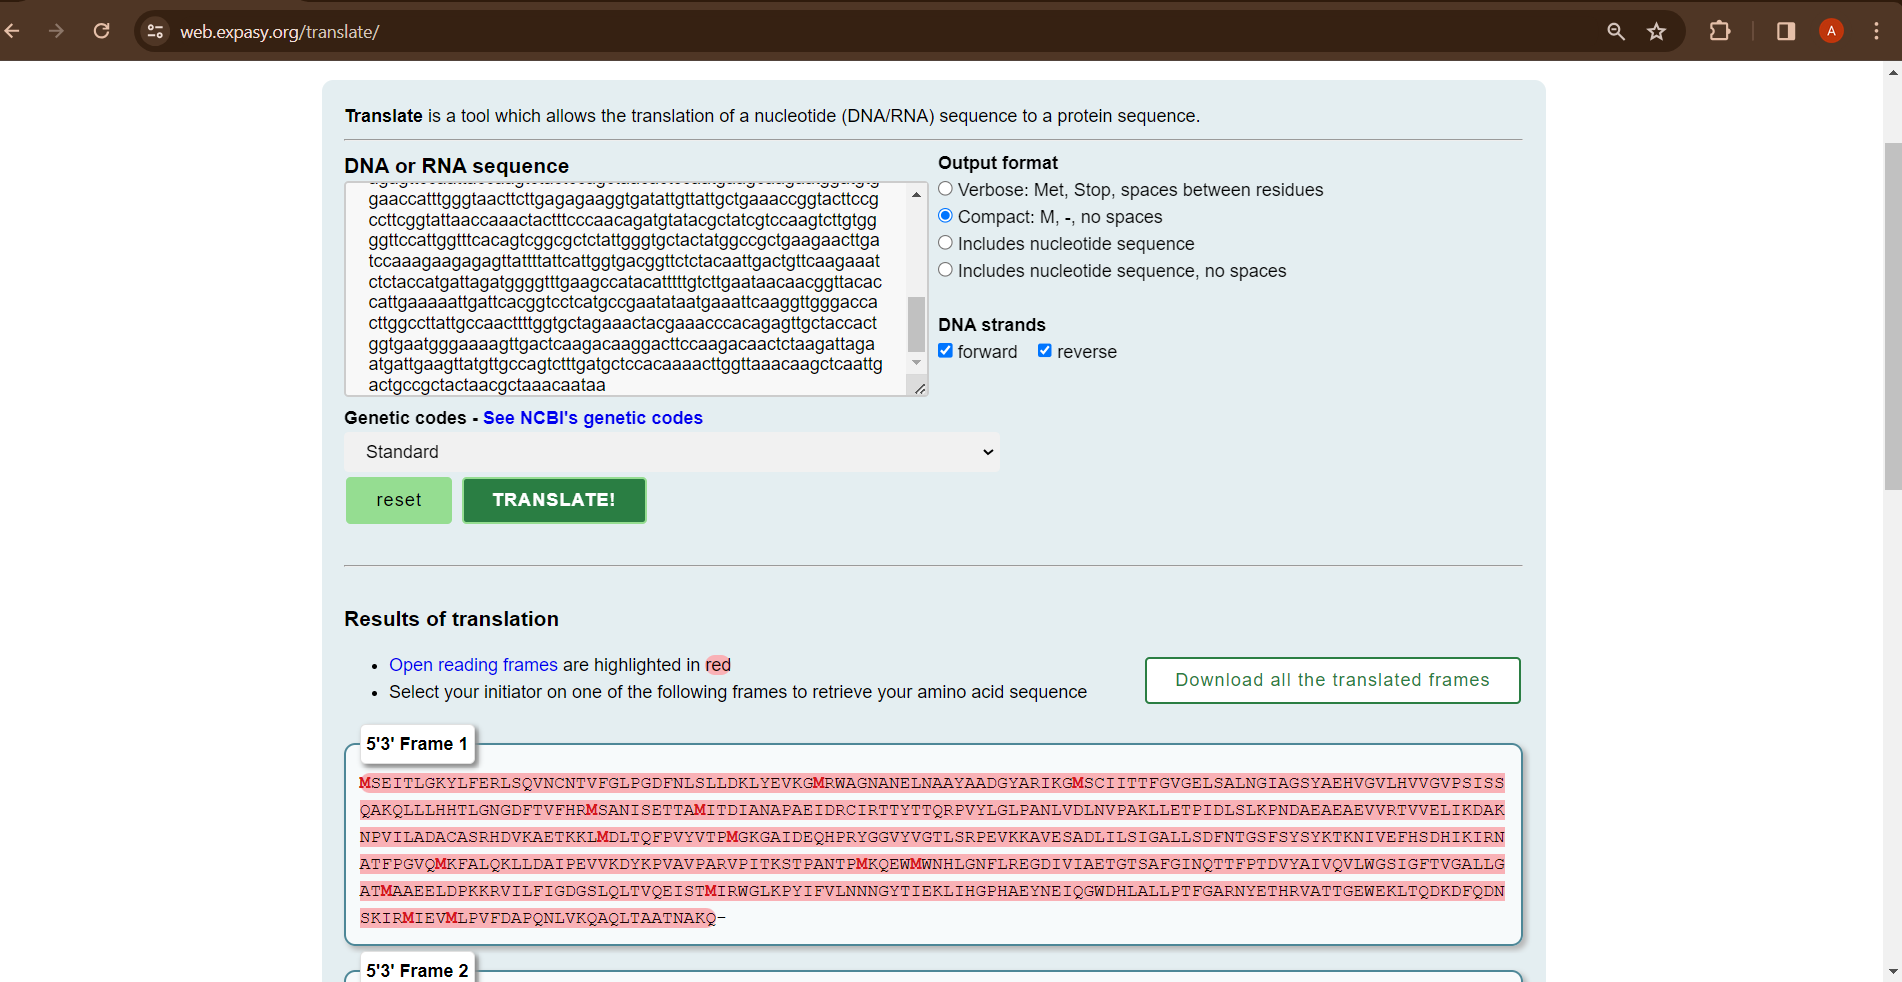

### Select a SNP within the PDC gene. Utilize tools like SIFT (Sorting Intolerant From Tolerant) or PolyPhen (Polymorphism Phenotyping) to predict the impact of the SNP on the PDC protein function.

We randomly choose any one SNP and run our query on Polyphen. The output has been attached.

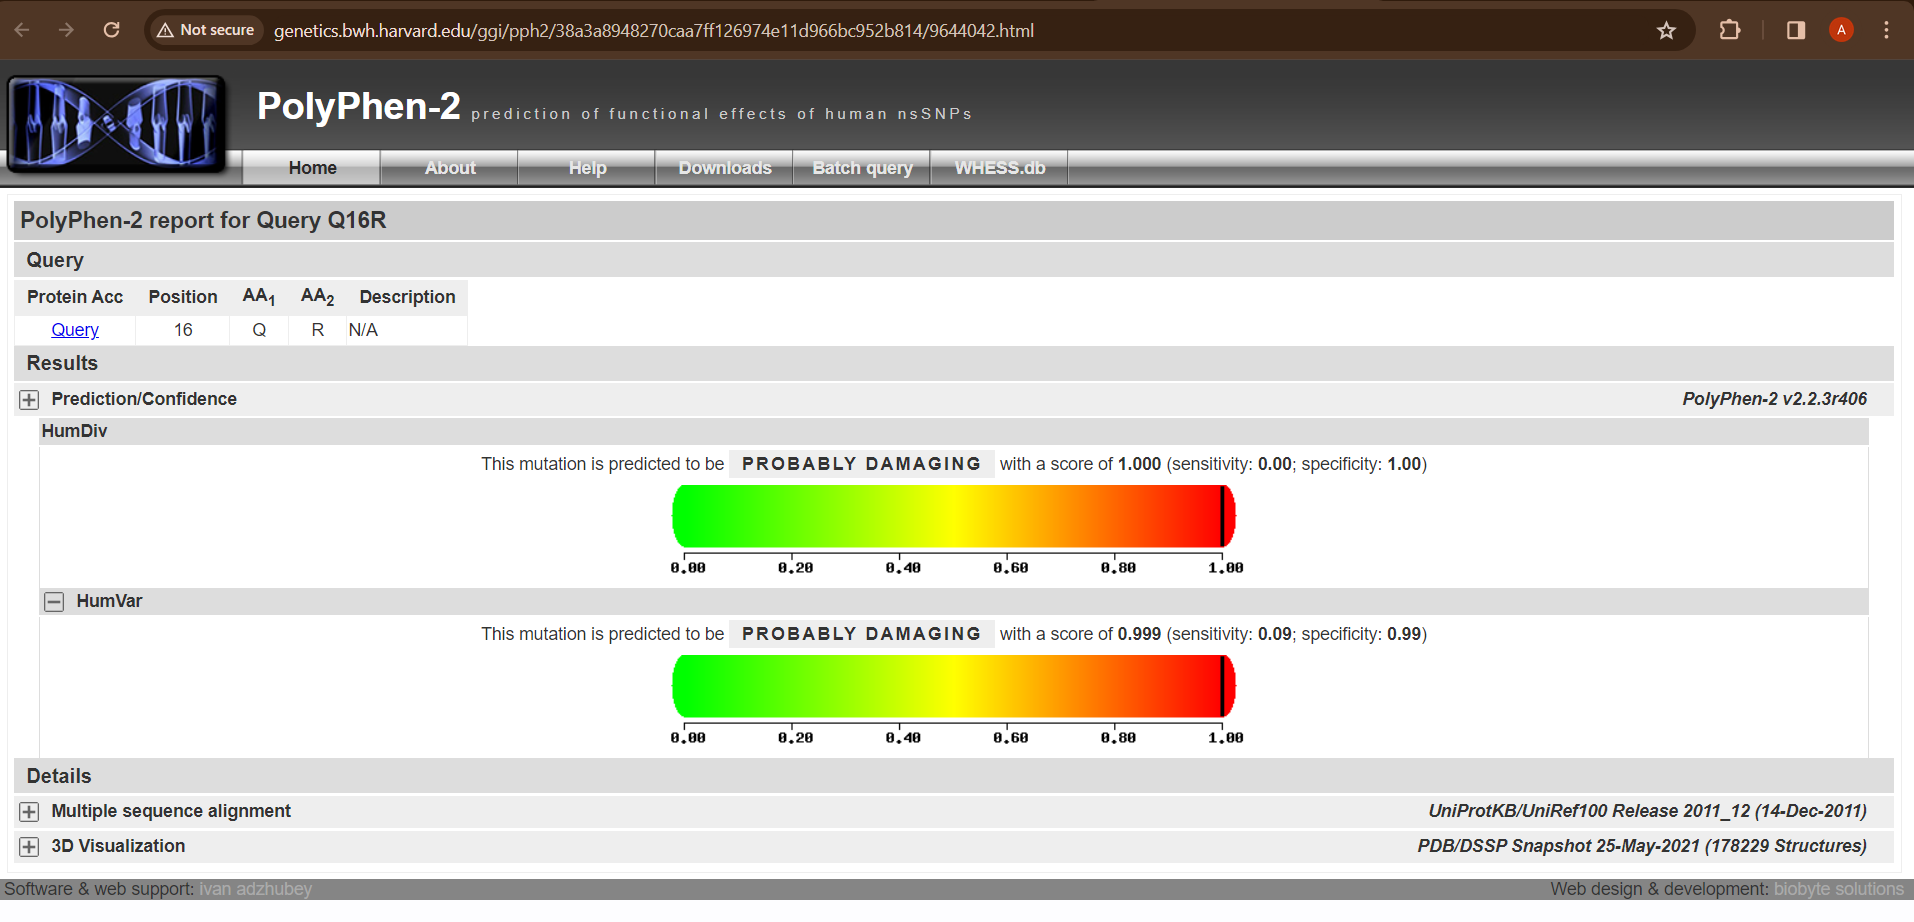

We see that in the selected sequence and with the selected SNP, when the amino acid Q changes to R, the effect is damaging. We come to a conclusion that different types of SNPs will have a different impact on the PDC protein function.